# Setup

### Path setup

In [1]:
import os

In [2]:
path_to_this_folder = os.getcwd() # Do it before calling %cd ../.. so that the path is accurate

### Project setup

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"   # Prevent internal ngsolve imports from killing the kernel


In [4]:
%cd ../..
!pip install .
!pip install meshio
!pip install ngsolve




c:\Users\octav\Documents\GitHub\Stage_ARIA
Processing c:\users\octav\documents\github\stage_aria
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for yourpkg: filename=yourpkg-0.1.0-py3-none-any.whl size=39613 sha256=efb78d8f40a74af04bbb0aa19ca4fe47227a386607d378cb0a5e0d253910c4d8
  Stored in directory: C:\Users\octav\AppData\Local\Temp\pip-ephem-wheel-cache-8h0tmmjt\wheels\2f\97\6f\4cd56f403f3905a3673325538741a3519ba70ae59cdd7d492e
Successfully built yourpkg
  Attempting uninstall: yourpkg
    Found existing installation: yourpkg 0.1.0
    Uninstalling yourpkg-0.1.0:
      Successfully uninstalled yourpkg-0.1.0


### Imports

Usual libraries

In [5]:
import tomllib
from time import time
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from ngsolve import Mesh, H1, BilinearForm, LinearForm, GridFunction, dx, grad, InnerProduct, Integrate
from netgen.read_gmsh import ReadGmsh

import numpy as np



Custom code

In [6]:
from src.Pre_processing.process_hardware import get_precision, get_device
from src.Pre_processing.process_gmsh import read_gmsh, get_nodes_and_elements_IDs
from src.FENN.VertexNN.FEENN_2D.FEENN import FEENN_2D
from src.FENN.VertexNN.FEENN_2D.Element import Tri_2D_lin
from src.FENN.VertexNN.FEENN_2D.Mapping import Mapping_2D_Affine
from src.FENN.ConstantNN.constantNN import ConstantNN
from src.FENN.L2NN.field_L2NN import Field_L2NN
from src.PropertiesNN.PropertiesNN import PropertiesNN
from src.Pre_processing.build_solver import build_solver
from src.PDE.optim_2D import Optim_2D_loss
from src.PDE.operators import curl
from src.PDE.magnetostatic_2D import Magnetostatic_2D
from src.MaterialNN.BinarySelection import BinarySelection
from src.Baselines.Poisson_2D.Uniform.baseline import baseline
from src.Post_processing.VTKExport.export_vtk import export_vtk



### Number precision

In [7]:
IntPrecision = torch.int32
FloatPrecision = torch.float64

### Hardware

Note that for cases of small meshes cpu outperforms gpu

In [8]:
device = 'cpu'

# Problem description and problem-related variables definition

$$
\begin{align*}
        \;&\text{Find }&&\overrightarrow{A}^* =\arg\min_{\overrightarrow{A}\in H\left(\overrightarrow{\text{rot}},\Omega\right)}\int_\Omega \frac{1}{2\mu(x)}\cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right)\cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right)-\overrightarrow{j}\cdot\overrightarrow{A}\text{d}\Omega\\\\
        &\text{s.t}&&\overrightarrow{A}(x^+)\cdot \overrightarrow{e}_z=A_0\\
        &&&\overrightarrow{A}(x^-)\cdot \overrightarrow{e}_z = -A_0\\
        &&&\overrightarrow{A}(x) = \overrightarrow{0}&\forall x\in\partial \Omega\\
        &&&\mu(x) = \mu_0&\forall x\in \Omega \backslash \Omega^+\bigcup\Omega^-\\
        &&&\mu(x) = \mu_1&\forall x\in\Omega^+\bigcup\Omega^-\\
        &&&\overrightarrow{j}(x) = \overrightarrow{0}&\forall x\in \Omega\\
        
    \end{align*}
$$

$\Omega$ is defined through a .msh file

In [9]:
# path_to_msh = os.path.join(path_to_this_folder, "Coil.msh")
# path_to_msh = os.path.join(path_to_this_folder, "Coil_fine.msh")
path_to_msh = os.path.join(path_to_this_folder, "Coil_interm.msh")

$\mu$ can have two values $\mu_0$ or $\mu_1$ depending on the location in $\Omega$.  
For conveniency 
- we use $\nu = \frac{1}{\mu}$
- we enforce the switch between $\nu_0$ and $\nu_1$ through a choice field $p:\Omega\to\{0,1\}$ such that
$$
\nu(x) = (1-p(x))\nu_0 +p(x)\nu_1
$$

In [10]:
# nu_0_value = 1/1*4*np.pi*1e-7
# nu_1_value = 2e-4

nu_0_value = 1/(4*np.pi*1e-7)
nu_1_value = 1/(4*np.pi*1e-7*5000)

No source term because $\overrightarrow{j} = \overrightarrow{0}$ in $\Omega$.

The problem is set in 2D

In [11]:
interior_dim = 2
boundary_dim = 1

$\overrightarrow{A}$ is a vector field that can be represented as a scalar field carried by $\overrightarrow{e}_z$. Hence only one component is necessary to identify $\overrightarrow{A}$.

In [12]:
n_components = 1

dirichlet_exterior = {'entity_name'         : 'Exterior',
                        'Value'              : 0}

dirichlet_positive_source = {'entity_name'                       : 'Positive_source',
                            'entity_dim'                         : 0,
                            'Value'                              : 1 }

dirichlet_negative_source = {'entity_name'                       : 'Negative_source',
                            'entity_dim'                         : 0,
                            'Value'                              : -1}

dirichlet_config = [dirichlet_exterior, dirichlet_positive_source, dirichlet_negative_source]

We use a linear interpolation for our FEM representation of $V$. Therefore $\overrightarrow{\text{curl}}(\overrightarrow{A})$ is constant by element and the appropriate integration scheme is an order 1 gaussian quadrature.

In [13]:
quadrature_order = 1

# Baseline with NGSolve

Solve the problem with NGSolve to get a baseline.

Fore more info, see : https://docu.ngsolve.org/latest/

#### Practical considerations

In our specific case $\overrightarrow{A} = A\overrightarrow{e}_z$. Consequently 
$$
\overrightarrow{\text{curl}}(\overrightarrow{A}) = \left(\begin{array}{c}\frac{\partial A}{\partial y}\\\\-\frac{\partial A}{\partial x}\end{array}\right)
$$

Thus, in our case,
$$
\overrightarrow{\text{curl}}(\overrightarrow{A})\cdot \overrightarrow{\text{curl}}(\overrightarrow{A}) = \left(\frac{\partial A}{\partial x}\right)^2 + \left(\frac{\partial A}{\partial y}\right)^2 = \nabla A\cdot \nabla A
$$

So, practicaly, we can replace the vector field $\overrightarrow{A}$ by its scalar representation $A$ and consider a gradient-based equivalent energy functionnal, which is easier to implement.

#### Implementation

In [14]:
"""
# Extract the mesh-related info from gmsh
mesh = Mesh(ReadGmsh(path_to_msh))
boundaries = mesh.GetBoundaries()

# Set the problem 
dirichlet = 'Exterior'

fes = H1(mesh, order = 1, dirichlet = dirichlet)

A = fes.TrialFunction()
A_test = fes.TestFunction()




bf = BilinearForm(fes)
bf += ((nu_1_value*grad(A)*grad(A_test))*dx('coil_1')) + ((nu_1_value*grad(A)*grad(A_test))*dx('coil_2')) + ((nu_0_value*grad(A)*grad(A_test))*dx('domain_no_coil'))

bf.Assemble()

# Solve
sol = GridFunction(fes)
sol.vec.data = bf.mat.Inverse(fes.FreeDofs(), inverse = "sparsecholesky")

# Get energy
energy_field = (Integrate((0.5 * nu_1_value *  grad(sol)*grad(sol))*dx('coil_1'), mesh)) + (Integrate((0.5 * nu_1_value *  grad(sol)*grad(sol))*dx('coil_2'), mesh)) + (Integrate((0.5 * nu_0_value *  grad(sol)*grad(sol))*dx('domain_no_coil'), mesh))
energy = energy_field - energy_source
"""

'\n# Extract the mesh-related info from gmsh\nmesh = Mesh(ReadGmsh(path_to_msh))\nboundaries = mesh.GetBoundaries()\n\n# Set the problem \ndirichlet = \'Exterior\'\n\nfes = H1(mesh, order = 1, dirichlet = dirichlet)\n\nA = fes.TrialFunction()\nA_test = fes.TestFunction()\n\n\n\n\nbf = BilinearForm(fes)\nbf += ((nu_1_value*grad(A)*grad(A_test))*dx(\'coil_1\')) + ((nu_1_value*grad(A)*grad(A_test))*dx(\'coil_2\')) + ((nu_0_value*grad(A)*grad(A_test))*dx(\'domain_no_coil\'))\n\nbf.Assemble()\n\n# Solve\nsol = GridFunction(fes)\nsol.vec.data = bf.mat.Inverse(fes.FreeDofs(), inverse = "sparsecholesky")\n\n# Get energy\nenergy_field = (Integrate((0.5 * nu_1_value *  grad(sol)*grad(sol))*dx(\'coil_1\'), mesh)) + (Integrate((0.5 * nu_1_value *  grad(sol)*grad(sol))*dx(\'coil_2\'), mesh)) + (Integrate((0.5 * nu_0_value *  grad(sol)*grad(sol))*dx(\'domain_no_coil\'), mesh))\nenergy = energy_field - energy_source\n'

Chat GPT baseline

In [15]:
"""
# -----------------------
# Mesh
# -----------------------
mesh = Mesh(ReadGmsh(path_to_msh))

print("Boundaries   =", mesh.GetBoundaries())
print("BBoundaries  =", mesh.GetBBoundaries())   # should contain your two point tags

pos_name = dirichlet_positive_source["entity_name"]   # "Positive_source"
neg_name = dirichlet_negative_source["entity_name"]   # "Negative_source"
pos_val  = dirichlet_positive_source["Value"]         # 1
neg_val  = dirichlet_negative_source["Value"]         # -1

# -----------------------
# FE space (H1 scalar A)
# -----------------------
fes = H1(mesh,
         order=1,
         dirichlet="Exterior",                          # keep if you want A=0 on Exterior
         dirichlet_bbnd=f"{pos_name}|{neg_name}")        # point Dirichlet (2D vertices) :contentReference[oaicite:1]{index=1}

A, A_test = fes.TnT()

# -----------------------
# Bilinear form: ∫ curl(A)·curl(test) = ∫ grad(A)·grad(test) in 2D for A ez
# -----------------------
a = BilinearForm(fes, symmetric=True)
a += nu_1_value * InnerProduct(grad(A), grad(A_test)) * dx("coil_1")
a += nu_1_value * InnerProduct(grad(A), grad(A_test)) * dx("coil_2")
a += nu_0_value * InnerProduct(grad(A), grad(A_test)) * dx("domain_no_coil")
a.Assemble()

# -----------------------
# RHS (zero unless you add sources)
# -----------------------
f = LinearForm(fes)
# f += ...   # add volume/source terms here if needed
f.Assemble()

# -----------------------
# Dirichlet data u_D (including point values)
# -----------------------
gfu = GridFunction(fes)  # will hold u_D, then overwritten with solution

def set_point_value(bbnd_name, value):
    reg = mesh.BBoundaries(bbnd_name)
    dofs = fes.GetDofs(reg)                              # BitArray of dofs in that region :contentReference[oaicite:2]{index=2}
    for i in range(fes.ndof):
        if dofs[i]:
            gfu.vec.data[i] = value

set_point_value(pos_name, pos_val)
set_point_value(neg_name, neg_val)

# -----------------------
# Solve inhomogeneous Dirichlet: u = u_D + A^{-1}(f - A u_D)
# -----------------------
inv = a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky")
gfu.vec.data += inv * (f.vec - a.mat * gfu.vec)         # gfu is now the solution :contentReference[oaicite:3]{index=3}

# -----------------------
# Energy
# -----------------------
energy_field = (
    Integrate(0.5 * nu_1_value * InnerProduct(grad(gfu), grad(gfu)) * dx("coil_1"), mesh) +
    Integrate(0.5 * nu_1_value * InnerProduct(grad(gfu), grad(gfu)) * dx("coil_2"), mesh) +
    Integrate(0.5 * nu_0_value * InnerProduct(grad(gfu), grad(gfu)) * dx("domain_no_coil"), mesh)
)
energy = energy_field - energy_source

baseline = gfu
baseline_mesh = mesh
"""


'\n# -----------------------\n# Mesh\n# -----------------------\nmesh = Mesh(ReadGmsh(path_to_msh))\n\nprint("Boundaries   =", mesh.GetBoundaries())\nprint("BBoundaries  =", mesh.GetBBoundaries())   # should contain your two point tags\n\npos_name = dirichlet_positive_source["entity_name"]   # "Positive_source"\nneg_name = dirichlet_negative_source["entity_name"]   # "Negative_source"\npos_val  = dirichlet_positive_source["Value"]         # 1\nneg_val  = dirichlet_negative_source["Value"]         # -1\n\n# -----------------------\n# FE space (H1 scalar A)\n# -----------------------\nfes = H1(mesh,\n         order=1,\n         dirichlet="Exterior",                          # keep if you want A=0 on Exterior\n         dirichlet_bbnd=f"{pos_name}|{neg_name}")        # point Dirichlet (2D vertices) :contentReference[oaicite:1]{index=1}\n\nA, A_test = fes.TnT()\n\n# -----------------------\n# Bilinear form: ∫ curl(A)·curl(test) = ∫ grad(A)·grad(test) in 2D for A ez\n# ----------------------

# FENN solve

Read the gmsh file and get the mesh related info

In [16]:
gmsh_mesh = read_gmsh(path_to_msh = path_to_msh,
                      IntPrecision = IntPrecision,
                      FloatPrecision = FloatPrecision)

Nodes = gmsh_mesh.nodes
connectivity = gmsh_mesh.elements[str(interior_dim)]['connectivity']

Processing GMSH file:  54%|█████▎    | 12549/23409 [00:00<00:00, 124591.25it/s]

Processing GMSH file: 100%|██████████| 23409/23409 [00:00<00:00, 98869.63it/s] 


Build a field candidate

In [17]:
# Build the field candidate. Here we use a linear interpolation scheme.
A = FEENN_2D(Nodes = Nodes,
            connectivity=connectivity,
            n_components=1,
            element=Tri_2D_lin(IntPrecision=IntPrecision, FloatPrecision=FloatPrecision),
            mapping = Mapping_2D_Affine(),
            IntPrecision=IntPrecision,
            FloatPrecision=FloatPrecision)

# Apply dirichlet
for dirichlet in dirichlet_config:

    nodeIDs, _ = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim = dirichlet.get('entity_dim', 1),
                                            entity_name = dirichlet.get('entity_name', None),
                                            entity_tag = dirichlet.get('entity_tag', None))
    
    
    value = dirichlet['Value']*torch.ones_like(nodeIDs, dtype = FloatPrecision).unsqueeze(-1)

    A.SetBCs(Fixed_nodal_coordinates_Ids = nodeIDs,
            Fixed_nodal_values_Ids = nodeIDs,
            Fixed_nodal_values_values = value)
    

# Specify the integration scheme
A.SetQuad(quadrature_order = quadrature_order)
A.Freeze(freeze_grid=True, freeze_interpolation=False)

# Move the object to the chosen hardware
A.to(device)

# Specify that A should store its evolution so that we can export it to vtk
A.StoreResults()

c:\Users\octav\Documents\GitHub\Stage_ARIA\src\FENN\VertexNN\FEENN_2D\FEENN.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('connectivity', torch.tensor(connectivity, dtype = self.ref_int.dtype))


Define the material.

In [18]:
# Define the nu_0 property
nu_0 = ConstantNN(property_value=nu_0_value,
                    IntPrecision = IntPrecision,
                    FloatPrecision = FloatPrecision)

# nu_0 is not a field to be found
nu_0.setBCs(is_fixed=True)

# Define the nu_1 property
nu_1 = ConstantNN(property_value=nu_1_value,
                    IntPrecision = IntPrecision,
                    FloatPrecision = FloatPrecision)

# nu_1 is not a field to be found
nu_1.setBCs(is_fixed=True)


# Define the nu property using nu_0 and nu_1
# BinarySelection.forward(el_ids, NPoints, *args, **kwargs) -> (1-choice)*self.properties['property_1'](el_ids, NPoints, *args, **kwargs) + choice*self.properties['property_2'](el_ids, NPoints, *args, **kwargs)
# nu = BinarySelection(property_1     = nu_0,
#                     property_2     = nu_1,
#                     NElem          = len(connectivity),
#                     IntPrecision   = IntPrecision,
#                     FloatPrecision = FloatPrecision)

nu = BinarySelection(property_1     = nu_0,
                    property_2     = nu_1,
                    NElem          = len(connectivity),
                    IntPrecision   = IntPrecision,
                    FloatPrecision = FloatPrecision)

# Set the value of nu to nu_0 in "domain_no_coil"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'domain_no_coil')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.ones_like(elemIDs))

# Set the value of nu to nu_1 in "coil_1"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'coil_1')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))

# Set the value of nu to nu_1 in "coil_2"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'coil_2')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))

# The only problem-relevant material property is nu
Mat = PropertiesNN(dim = interior_dim,
                NElem = len(connectivity),
                IntPrecision = IntPrecision,
                FloatPrecision = FloatPrecision)

Mat.add_property(property_name = 'nu',
                property = nu)

# Move the object to the chosen hardware
Mat.to(device)

PropertiesNN(
  (properties): ModuleDict(
    (nu): BinarySelection(
      (soft_choice): ParameterDict(
          (free): Parameter containing: [torch.DoubleTensor of size 0]
          (imposed): Parameter containing: [torch.DoubleTensor of size 15392]
      )
      (properties): ModuleDict(
        (property_1): ConstantNN()
        (property_2): ConstantNN()
      )
      (sigmoid): Sigmoid()
    )
  )
)

Define the objective function and how the fields of interest should be saved

In [19]:
vtk_export_config = {'path_to_folder'       : os.path.join(os.path.join(path_to_this_folder, 'Results'), 'VTK_exports'),
                    'cell_data'             : ['B', 'potential', 'j', 'field_term', 'source_term', 'nu', 'mapping_det'],
                    'point_data'            : ['A'],
                    'export_vtk'            : True}

energy_functionnal = Magnetostatic_2D(IntPrecision=IntPrecision, 
                                    FloatPrecision=FloatPrecision,
                                    vtk_export = vtk_export_config)

Specify the solver and build it. Here, the objective is convex so LBFGS (quasi-Newton) is appropriate.

In [20]:
solver_config = {'optimizer'               :  'lbfgs',
            'n_epochs'                :  5000,
            'loss_decrease_c'         :   1e-13,
            'freeze_grid'             :   True,
            'freeze_interpolation'    :   False,
            'freeze_Mat'              :   True}

solver = build_solver(solver_config = solver_config,
                      loss = energy_functionnal,
                      model = A,
                      Mat = Mat,
                      # baseline = baseline,            
                      # baseline_mesh = baseline_mesh,  
                      )

solver.solve()

Solving (worse case scenario):  14%|█▍        | 699/5000 [12:22<22:23,  3.20it/s, time=743]   

Export the loss

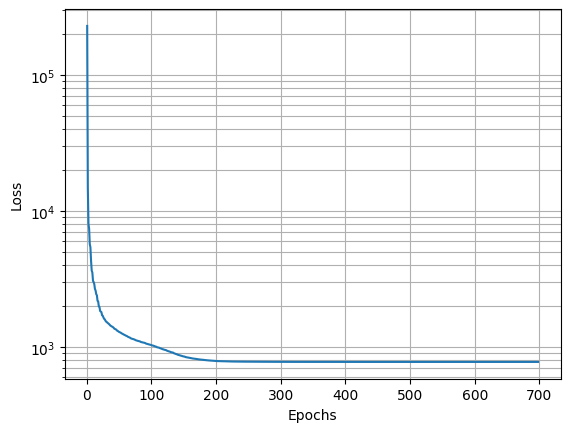

In [21]:
epochs, loss = solver.get_metric()

# Define the path to the main plot save folder
save_folder = os.path.join(os.path.join(path_to_this_folder, 'Results'), 'Plots')
os.makedirs(save_folder, exist_ok=True)

# Plot and save the loss evolution
save_name = f"loss.png"
save_path = os.path.join(save_folder, save_name)
plt.clf()
plt.plot(epochs, loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, which='both')
plt.savefig(save_path)

See the results in the VTK file